In [ ]:
# ---------------------------------------------
# 1. Import Libraries
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings("ignore")


In [6]:
# ---------------------------------------------
# 2. Load Dataset
# ---------------------------------------------
df = pd.read_csv("C:\\Users\\Sindu\\Desktop\\Assignment ExcelR\\Clustering\\Clustering\\EastWestAirlines.xlsx.csv")
df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [8]:
# ---------------------------------------------
# 3. Data Preprocessing
# ---------------------------------------------

# Drop ID column if present
if 'ID#' in df.columns:
    df.drop(columns=['ID#'], inplace=True)

# Check missing values
print("Missing Values:\n", df.isnull().sum())

# Remove outliers using IQR method
def remove_outliers(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df = remove_outliers(df)

# Scaling the features
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


Missing Values:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


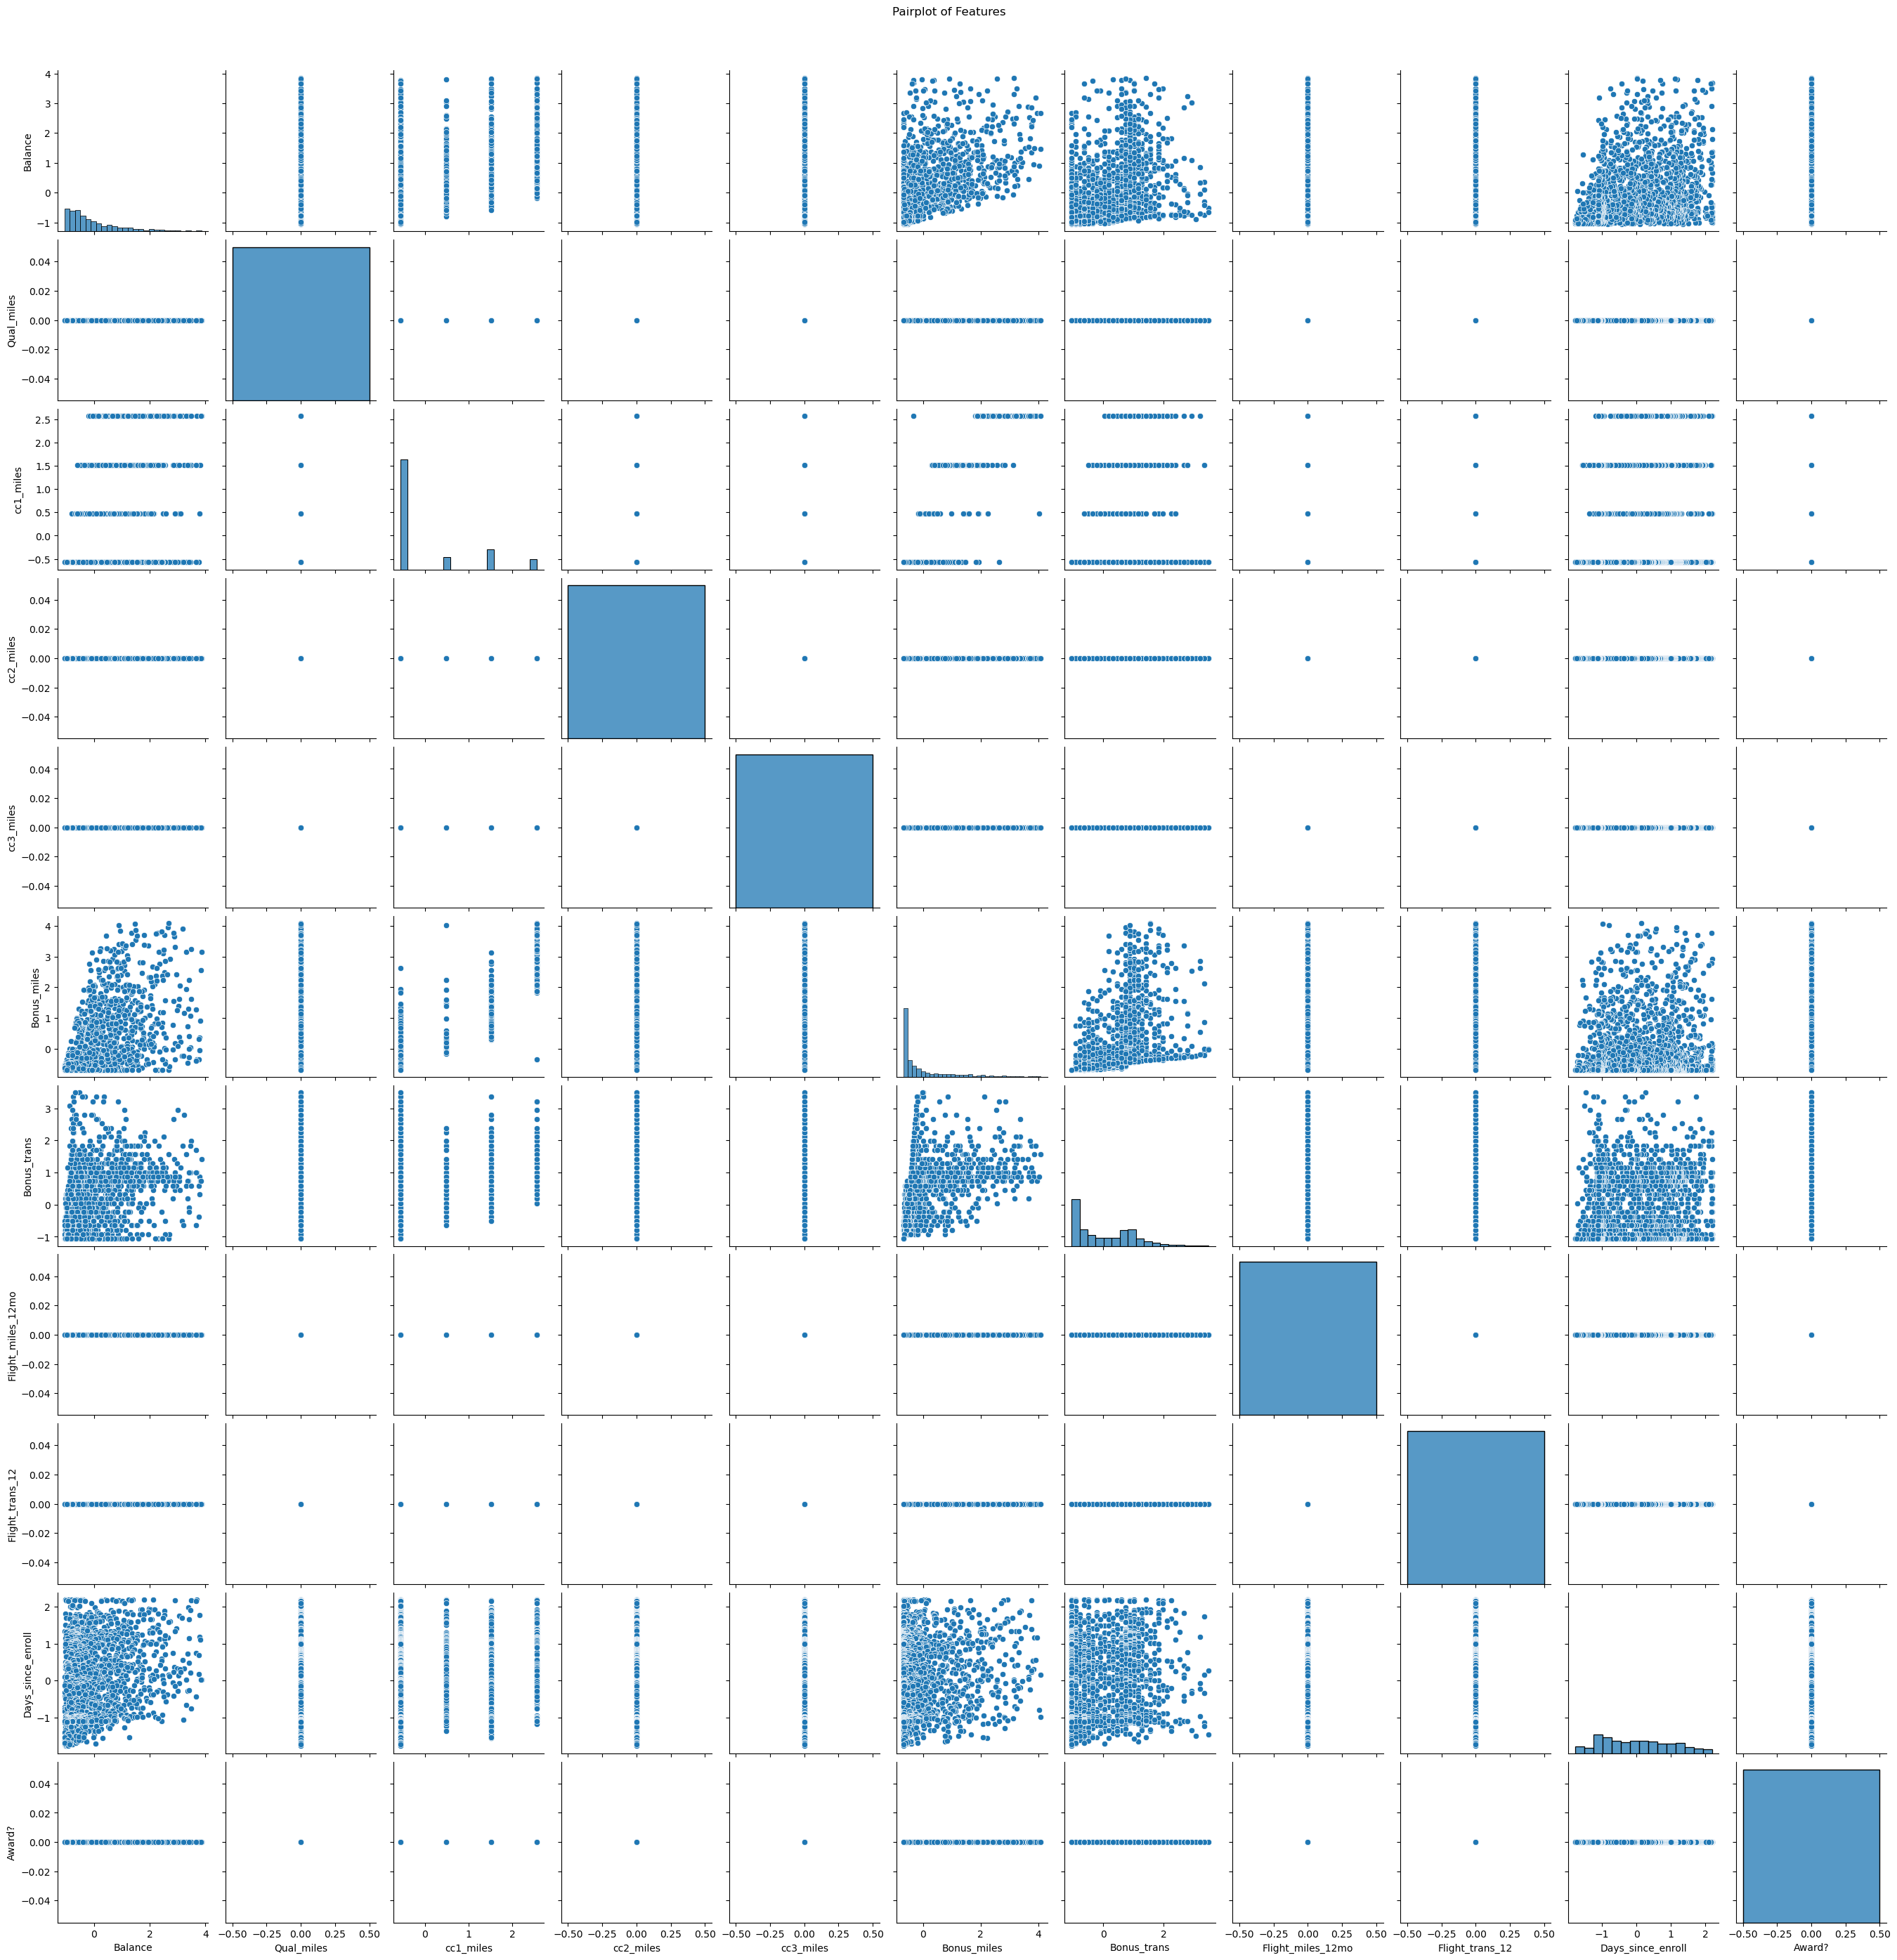

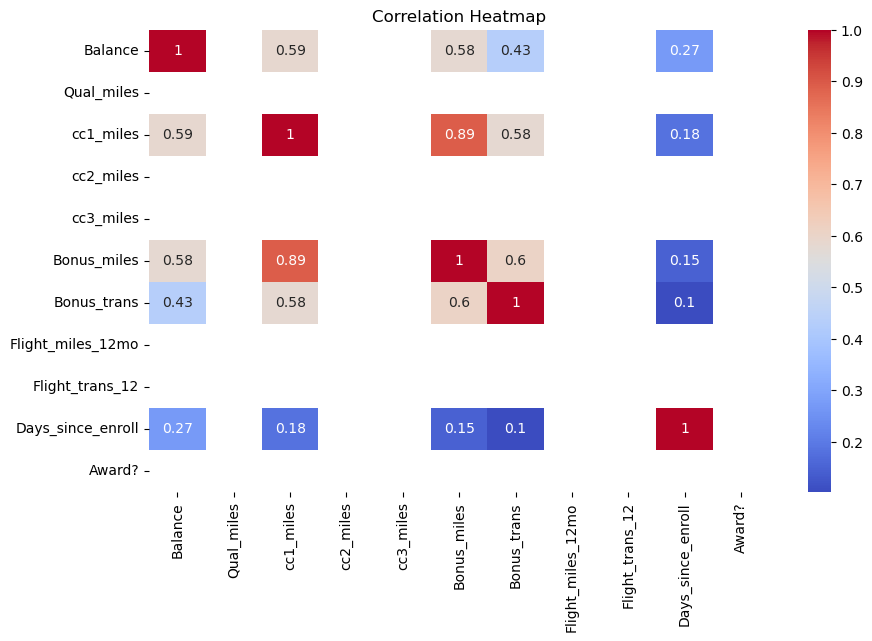

In [12]:
# ---------------------------------------------
# 4. Exploratory Data Analysis (EDA)
# ---------------------------------------------
sns.pairplot(scaled_df)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


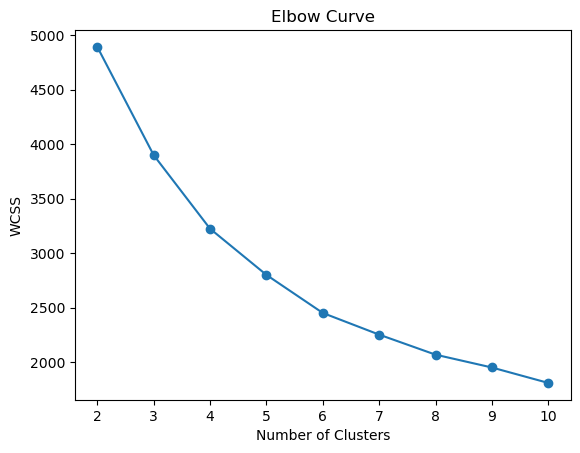

KMeans Silhouette Score: 0.3125567081861358


In [14]:
# ---------------------------------------------
# 5. K-Means Clustering
# ---------------------------------------------

# Elbow Method to find optimal K
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply KMeans with optimal K
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df)
df['KMeans_Cluster'] = kmeans_labels

# KMeans Evaluation
print("KMeans Silhouette Score:", silhouette_score(scaled_df, kmeans_labels))


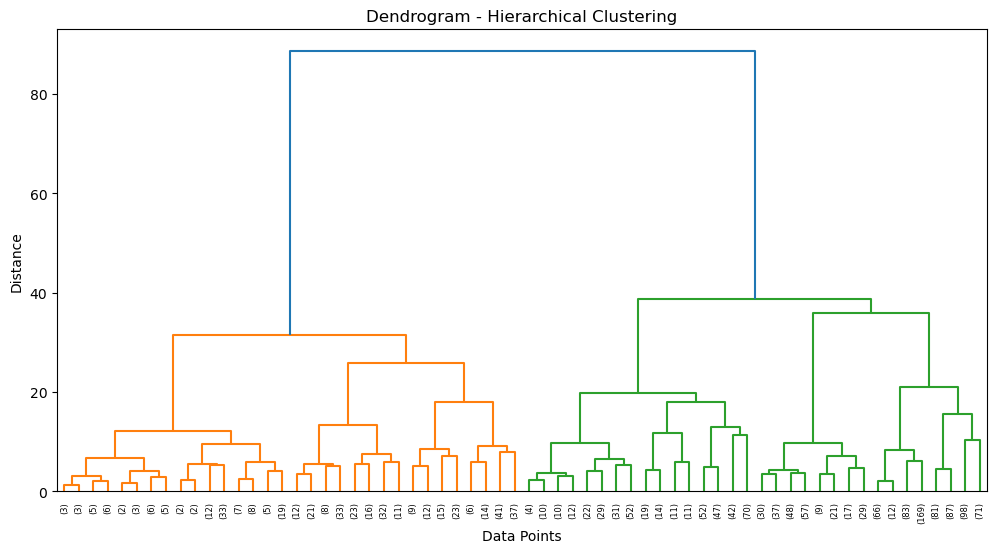

Hierarchical Silhouette Score: 0.26515878012310307


In [15]:
# ---------------------------------------------
# 6. Hierarchical Clustering
# ---------------------------------------------
link = linkage(scaled_df, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(link, truncate_mode='level', p=5)
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Apply Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hier_labels = hierarchical.fit_predict(scaled_df)
df['Hierarchical_Cluster'] = hier_labels

# Hierarchical Evaluation
print("Hierarchical Silhouette Score:", silhouette_score(scaled_df, hier_labels))


In [23]:
# ---------------------------------------------
# 7. DBSCAN Clustering
# ---------------------------------------------
# Step 1: Remove outliers
df_clean = remove_outliers(df)

# Step 2: Scale the cleaned DataFrame
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns, index=df_clean.index)

# Step 3: Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(scaled_df)

# Store DBSCAN labels in df_clean
df_clean['DBSCAN_Cluster'] = db_labels

# Step 4: Filter non-noise points (-1)
non_noise_mask = df_clean['DBSCAN_Cluster'] != -1
db_labels_filtered = df_clean.loc[non_noise_mask, 'DBSCAN_Cluster']
scaled_df_filtered = scaled_df.loc[non_noise_mask]

# Step 5: Evaluate
if len(set(db_labels_filtered)) > 1:
    print("DBSCAN Silhouette Score:", silhouette_score(scaled_df_filtered, db_labels_filtered))
else:
    print("DBSCAN did not find enough clusters to calculate silhouette score.")


DBSCAN Silhouette Score: 0.39107606289056085


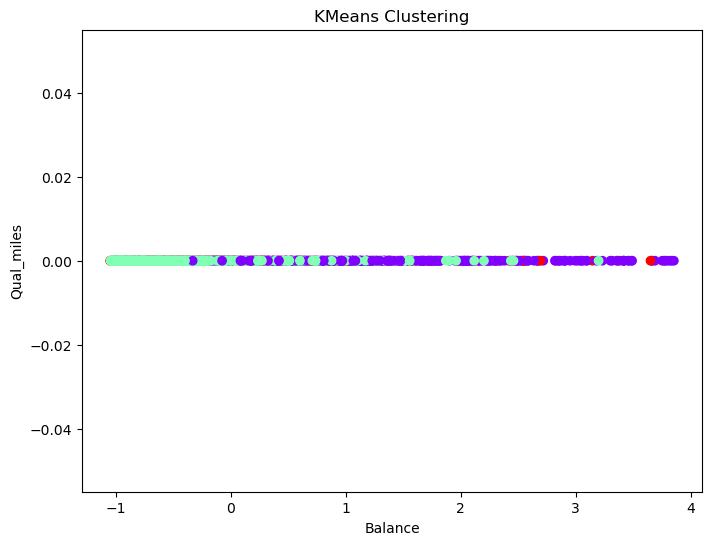

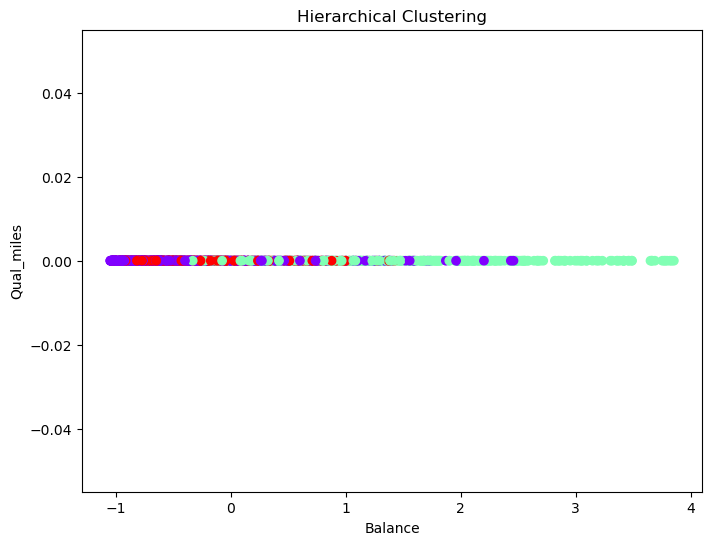

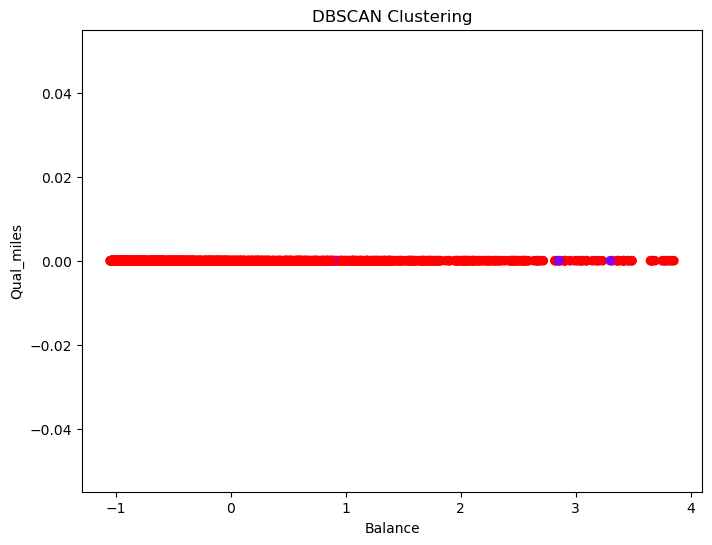

In [17]:
# ---------------------------------------------
# 8. Visualization of Clusters
# ---------------------------------------------
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=labels, cmap='rainbow')
    plt.title(title)
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

plot_clusters(scaled_df, kmeans_labels, 'KMeans Clustering')
plot_clusters(scaled_df, hier_labels, 'Hierarchical Clustering')
plot_clusters(scaled_df, db_labels, 'DBSCAN Clustering')


In [21]:
# ---------------------------------------------
# 9. Cluster Insights (Example)
# ---------------------------------------------
print("\nCluster Characteristics (KMeans):")
print(df.groupby('KMeans_Cluster').mean())

print("\nCluster Characteristics (Hierarchical):")
print(df.groupby('Hierarchical_Cluster').mean())



Cluster Characteristics (KMeans):
                     Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                              
0               87727.205251         0.0   3.100239        1.0        1.0   
1               24077.619236         0.0   1.065876        1.0        1.0   
2               33599.210873         0.0   1.072488        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0               22572.188544    15.279236                0.0              0.0   
1                2429.017128     5.408432                0.0              0.0   
2                2352.845140     5.286656                0.0              0.0   

                Days_since_enroll  Award?  Hierarchical_Cluster  \
KMeans_Cluster                                                    
0                     4413.434368     0